In [16]:

!pip install umap
!pip install umap-learn[plot]

In [17]:
import pandas as pd
import numpy as np



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import make_pipeline

from sklearn.manifold import TSNE
from umap import UMAP
import umap.plot

from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import log_loss

import os, time, gc
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
path = "/content/"
os.chdir(path)
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Files/MNIST/train.csv_2.zip")

In [21]:
train.shape                        
print()
train.head()
print()
train.dtypes.value_counts() 

(60000, 785)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


int64    785
dtype: int64

In [22]:
train.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [23]:
y = train.pop('label')

In [24]:
train.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,60000.0,60000.0,60000.0,60000.0,60000.0,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.000000,60000.0
mean,0.0,0.0,0.0,0.0,0.0,0.008817,0.029467,0.037767,0.075933,0.117500,0.188733,0.282250,0.273233,0.229967,0.136550,0.05765,0.022217,0.010200,0.005383,0.002383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000950,0.052617,0.145933,0.312750,0.793350,1.779850,2.897033,...,0.919667,0.583050,0.509150,0.610867,0.405600,0.250417,0.099417,0.017517,0.002667,0.003467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004250,0.049783,0.145800,0.227567,0.386967,0.438467,0.449250,0.449000,0.402717,0.292850,0.117067,0.049433,0.015583,0.016450,0.013417,0.022300,0.012217,0.001383,0.003783,0.0,0.002717,0.0
std,0.0,0.0,0.0,0.0,0.0,1.474271,2.700491,2.726371,3.993023,4.863581,6.062757,7.459661,7.287233,6.579045,5.158987,3.13942,2.088539,1.128635,0.938511,0.583795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173444,3.488517,5.744953,8.125368,12.840316,19.085054,24.416648,...,13.209596,10.461136,9.487791,11.370621,9.410021,7.470770,4.846386,2.013118,0.653197,0.849156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.041033,3.493209,5.700393,6.838696,9.134399,9.752470,9.868781,9.853733,9.346042,7.773776,4.726782,2.939535,1.443852,1.958914,1.342572,2.051846,1.730959,0.338846,0.926724,0.0,0.665445,0.0
min,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0

In [25]:
print("--Current memory usage (MB) --\n")
train.memory_usage().sum()/1000000  # 376.320128

print("\n\n--Max and min values---\n")
train.max().max()               # 255
print()
train.min().min()               # 0

train = train.astype('uint16')

print("\n\n--Revised memory usage (MB) --\n")
train.memory_usage().sum()/1000000  # 94.080128 MB

--Current memory usage (MB) --



376.320128



--Max and min values---



255

0



--Revised memory usage (MB) --



94.080128

In [26]:
le = LabelEncoder()
y = le.fit_transform(y)

In [27]:
ss = StandardScaler()
X = ss.fit_transform(train)

In [28]:
sss =  StratifiedShuffleSplit(
                              n_splits = 1,     # Need only 1-pair of splits
                              test_size = 30000
                              )


type(sss)             # StratifiedShuffleSplit
print()
type(sss.split(X,y))  # Generator

for train_index, test_index in sss.split(X, y):
    X_train = X[train_index,:]
    y_train = y[train_index]

sklearn.model_selection._split.StratifiedShuffleSplit

generator

In [29]:
pca = PCA(n_components=0.95)   # Explain 95% variance
Xf = pca.fit_transform(X_train)
Xf.shape

(30000, 405)

In [30]:
#Perform t-sne now.

start = time.time()
# Instantiate TSNE class
tsne = TSNE(
            perplexity = 30,  # Larger datasets usually require a larger perplexity.
                              # Experiment with selecting a value between 5 and 50.
            n_jobs = 2,
            )

# Fit and transform dataset to 2D

res = tsne.fit_transform(Xf)
end = time.time()
(end - start)/60   # 15 min

14.781253870328268

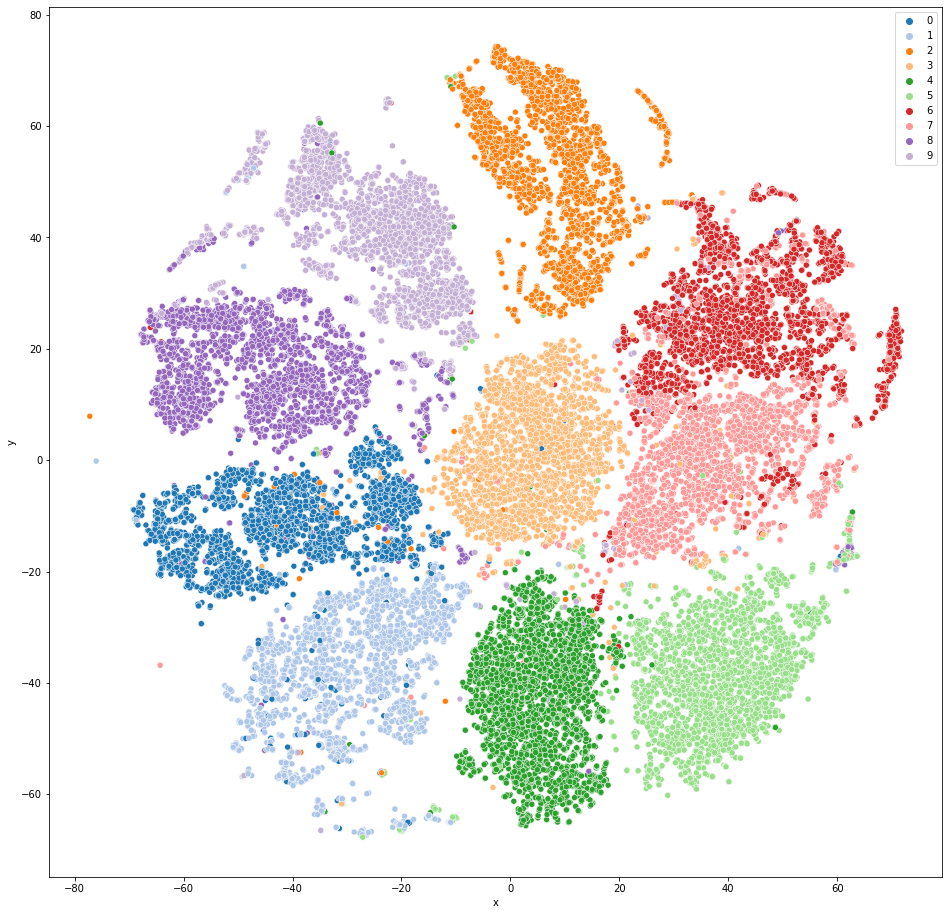

In [31]:
res = pd.DataFrame(res, columns= ['x','y'])
fig = plt.figure(figsize = (16,16))
_=sns.scatterplot(data=res, x='x', y='y', hue=y_train, palette='tab20')

In [32]:
start = time.time()
mapper = umap.UMAP().fit(X)       # Instantiation and fitting
embedding =  mapper.transform(X)  # Data transformation
end = time.time()
(end-start)/60  

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


1.6305798371632894

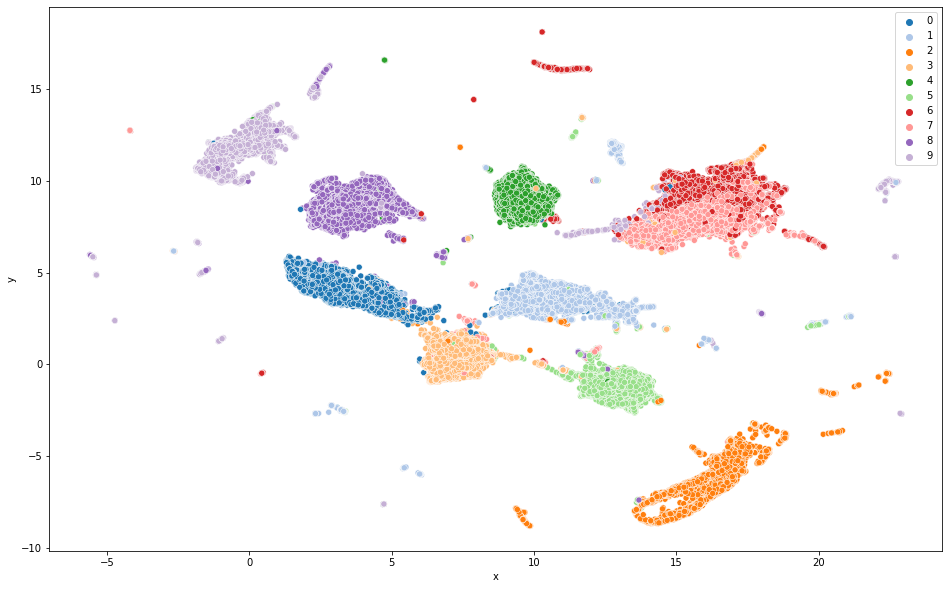

In [33]:
embedding = pd.DataFrame(embedding, columns= ['x','y'])
fig = plt.figure(figsize = (16,10))
_=sns.scatterplot(
                   data=embedding,
                   x='x',
                   y='y',
                   hue=y,          # Else use y_train
                   palette='tab20')

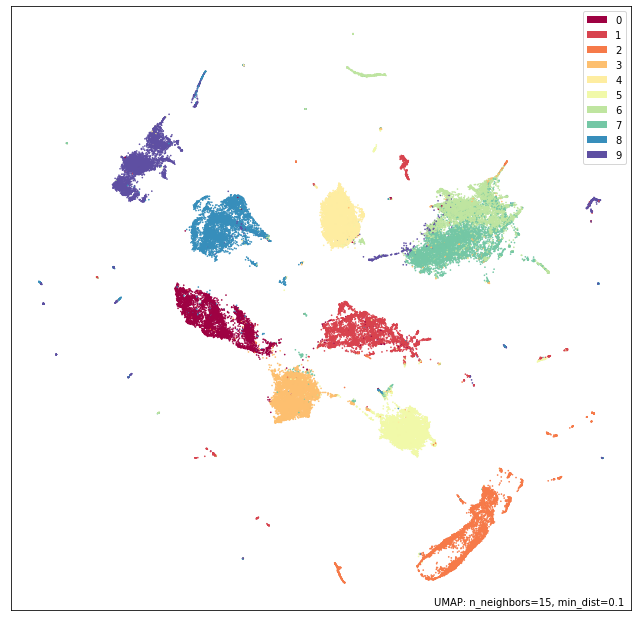

In [34]:
_=umap.plot.points(
                    mapper,
                    labels=y
                   )

In [35]:
# 6.0 Split data in stratified manner
# Perform stratified sampling

# 6.0.1
sss =  StratifiedShuffleSplit(n_splits = 1, test_size = 0.3)
# 6.0.2
for train_index, test_index in sss.split(train, y):
    X_train, X_test = train.loc[train_index,:],train.loc[test_index, :] 
    y_train, y_test = y[train_index], y[test_index]

In [42]:

# 6.1 Create pipeline, feed data and execute it
#     Note UMAP is a part of pipe()

start = time.time()
# 6.1.1
pipe1 = make_pipeline(
                     StandardScaler(),
                     PCA(n_components=0.95), 
                     UMAP(
                           n_neighbors=15,  # Something akin to perplexity
                           n_components = 5 # 5D output
                          ),
                      
                     RandomForestClassifier(max_depth =35)
                     )

# 6.1.2
pipe1.fit(X_train,y_train)

# 6.1.3
log_loss(y_test,y_pred)
end = time.time()
(end-start)/60

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('umap',
                 UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0,
                      dens_lambda=0.0, dens_var_shift=0.1, densmap=False,
                      disconnection_...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=35, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
             

0.8345264803654465

1.6458702246348063

In [40]:
def gen_features(data):     # Other arguments not possible
  # 7.1
  out = UMAP(n_neighbors=15, n_components = 2).fit_transform(data)
  # 7.2
  return np.hstack([data,out])

In [41]:
start = time.time()
# 8.1
pipe1 = make_pipeline(
                     StandardScaler(),
                     PCA(n_components=0.95), 
                     FunctionTransformer(gen_features),
                     RandomForestClassifier(max_depth=35,n_jobs=2,n_estimators=300)
                     )

# 8.2
pipe1.fit(X_train,y_train)
# 8.3
y_pred = pipe1.predict_proba(X_test)
# 8.4
print()
# 8.5
log_loss(y_test,y_pred)
end = time.time()
print()
(end -start)/60    # 6 minutes on Colab

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function gen_features at 0x7f1e840a8a70>,
                                     in...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=35, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impur

0.8345264803654465

5.818621591726939